In [1]:
%matplotlib inline

# This file contains all the main external libs fastai needs
from fastai.imports import *

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


the fastai notebooks imports all the functions into the global namespace, which I find confusing since I don't know what methods are fastai and what are coming from other libraries. 

Ideally I'd like to be able to just call `import fastai as fastai` rather than having multiple import statements. Anyways, using the defaults for now:

In [2]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
torch.cuda.is_available(), torch.backends.cudnn.enabled

(True, True)

# Data

I'm going to use a pretrained NN to solve [Kaggle's digit recognizer competition](https://www.kaggle.com/c/digit-recognizer/data), cause why not. I used https://github.com/floydwch/kaggle-cli to download the dataset, and look at the [fastai dataset.py file](https://github.com/fastai/fastai/blob/master/fastai/dataset.py) to figure out how to use it.

In [4]:
PATH = '/home/ubuntu/data/digit-recognizer/'
print(PATH)
os.listdir(PATH)

/home/ubuntu/data/digit-recognizer/


['submission.csv',
 'train',
 'test.csv',
 'tmp',
 'train_labels.csv',
 'test',
 'sample_submission.csv',
 'train.csv',
 'models']

Now to take a look at the data:

In [5]:
train = pd.read_csv(PATH + "train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test = pd.read_csv(PATH+"test.csv")
print(test.shape)
test.head(3)

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We need the data in a form the fast.ai library can ingest, so in this I'm going to make both numpy arrays and also save the images to disk, along with a csv file of the labels of the training image.

pytorch/fastai want image data to be in the same: `num_images, channels, height, width`, so I reshape the numpy arrays into 3 channel.

In [7]:
# grabbing the images from the datafram
train_images = train.iloc[:,1:].values.astype('float32')

# stacking them and reshaping
train_images_3D = (np.stack((train_images,)*3, -1)).reshape(-1, 3, 28, 28)
train_images_3D.shape

(42000, 3, 28, 28)

In [8]:
# grabbing the images from the datafram
test_images = test.values.astype('float32')

# stacking them and reshaping
test_images_3D = (np.stack((test_images,)*3, -1)).reshape(-1, 3, 28, 28)
test_images_3D.shape

(28000, 3, 28, 28)

In [12]:
# saving labels for training images to disk in a csv file
train.label.to_csv(PATH + "train_labels.csv")
!head /home/ubuntu/data/digit-recognizer/train_labels.csv

0,1
1,0
2,1
3,4
4,0
5,0
6,7
7,3
8,5
9,3


In [13]:
from PIL import Image

def save_images_from_array(arr,new_dir="train"):
    path = PATH + new_dir
    
    if os.path.isdir(path):
        print(f"dir {new_dir} at {PATH} already exists, saving there")
    else:
        print(f"Creating {new_dir} inside {PATH}")
        os.makedirs(path)
    
    for i, im in enumerate(tqdm(arr)):
        im = im.reshape(28,28,3)
        im = Image.fromarray(im.astype('uint8'))
        im.save(path + f"/{i}.jpeg")
    
save_images_from_array(train_images_3D, "train")
save_images_from_array(test_images_3D, "test")

dir train at /home/ubuntu/data/digit-recognizer/ already exists, saving there
100%|██████████| 42000/42000 [00:13<00:00, 3068.06it/s]
dir test at /home/ubuntu/data/digit-recognizer/ already exists, saving there
100%|██████████| 28000/28000 [00:09<00:00, 2863.09it/s]


In [14]:
print(PATH)
os.listdir(PATH)

/home/ubuntu/data/digit-recognizer/


['submission.csv',
 'train',
 'test.csv',
 'tmp',
 'train_labels.csv',
 'test',
 'sample_submission.csv',
 'train.csv',
 'models']

Finally, we can make the fast.ai data object. I am assuming the tfms from model normalizes the images, otherwise I should do that above.

In [29]:
arch = resnet34 # also try resnext101_64

sz = 28 # we have 28x28x3 image size. what should this number be?

# transforms
#tfms = tfms_from_model(resnet34, sz)
tfms = tfms_from_model(resnet34, sz)

train_csv = PATH + "train_labels.csv"
data = ImageClassifierData.from_csv(PATH, "train", train_csv, tfms=tfms, suffix=".jpeg", test_name='test')

Now to do a initial training run:

In [30]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 9)

100%|██████████| 438/438 [00:18<00:00, 23.32it/s]          


HBox(children=(IntProgress(value=0, description='Epoch', max=9), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.359602   0.230457   0.926223  
    1      0.315986   0.189565   0.941998                    
    2      0.297028   0.166169   0.947206                    
    3      0.271044   0.164597   0.949811                    
    4      0.252819   0.15663    0.949187                    
    5      0.248355   0.149086   0.953125                    
    6      0.229317   0.145862   0.954869                    
    7      0.223968   0.137013   0.956645                    
    8      0.216313   0.137      0.954632                    



[0.13700034, 0.9546322601311135]

Both training and validation loss are decreasing, so I should keep training this for a while longer.

In [31]:
lr = np.array([1e-4, 1e-3, 1e-2])
learn.unfreeze()
learn.precompute=False

learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.191833   0.13775    0.956321  
    1      0.196488   0.130693   0.95771                     
    2      0.182562   0.13127    0.959959                    
    3      0.209489   0.134222   0.958688                    
    4      0.188844   0.127974   0.95857                     
    5      0.176491   0.125089   0.959991                    
    6      0.173471   0.118859   0.961766                    



[0.11885865, 0.9617660984848485]

In [140]:
lr = np.array([1e-6, 1e-4, 1e-3])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.01853    0.034593   0.991241  
    1      0.022666   0.034979   0.989938                     
    2      0.024458   0.035057   0.990294                     
    3      0.017102   0.034032   0.98982                      
    4      0.022823   0.033808   0.98982                      
    5      0.016324   0.034801   0.989938                     
    6      0.014868   0.034699   0.989465                     



[0.034699105, 0.9894649621212122]

In [64]:
learn.data.trn_y

array([0, 9, 1, ..., 4, 7, 9])

In [46]:
train_preds = learn.predict()

In [48]:
train_preds

array([[-15.04975, -14.50609, -12.27575, ..., -17.76859,  -0.00007, -12.08151],
       [ -7.19669,  -8.47966,  -1.79667, ...,  -6.82505,  -2.48746,  -0.29834],
       [-11.79865, -18.2049 , -17.58971, ..., -11.43414, -11.21977,  -0.00003],
       ...,
       [ -0.00006, -12.1664 , -13.64796, ..., -11.98514, -11.35586, -12.64609],
       [-10.56205, -12.80682,  -0.00033, ...,  -8.93984, -11.73556, -11.48986],
       [-16.13748, -11.77705, -13.34096, ...,  -0.0001 , -17.25283,  -9.98694]], dtype=float32)

## now to predict

We already saved the images to predict in the `test` folder, so...

- learn.TTA() uses test time annealing and returns a tuple, with the first one being the log of probs and the second the y val

In [78]:
# to use TTA use this cell:
#test_log_preds = learn.TTA(is_test=True)
#test_probs = np.exp(test_log_preds[0])

In [34]:
test_log_preds = learn.predict(is_test=True)
test_log_preds[:5]

array([[-18.61616, -22.09646, -21.14815, -22.03671, -12.2824 , -20.40808, -18.64068, -17.39104, -17.30208,
         -0.     ],
       [-11.16195, -11.606  , -10.02012,  -8.31682, -12.25417,  -8.55904, -10.96333, -12.96287,  -0.0009 ,
         -7.90802],
       [ -0.00069,  -9.75426, -13.09994, -12.45181, -11.15996, -11.1117 ,  -8.13797, -11.35034,  -8.41773,
         -9.55787],
       [ -0.00344,  -6.69762,  -8.51568,  -9.91254,  -8.20491,  -9.71628,  -7.45117,  -8.26778,  -7.478  ,
         -8.45012],
       [-11.27612,  -0.00133, -14.00896, -13.06066, -11.62403, -13.21865,  -6.64894, -12.45409, -14.22827,
        -17.26545]], dtype=float32)

In [36]:
test_probs = np.exp(test_log_preds)
print(test_probs.shape)
test_probs[:5]

(28000, 10)


array([[0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 1.     ],
       [0.00001, 0.00001, 0.00004, 0.00024, 0.     , 0.00019, 0.00002, 0.     , 0.9991 , 0.00037],
       [0.99931, 0.00006, 0.     , 0.     , 0.00001, 0.00001, 0.00029, 0.00001, 0.00022, 0.00007],
       [0.99657, 0.00123, 0.0002 , 0.00005, 0.00027, 0.00006, 0.00058, 0.00026, 0.00057, 0.00021],
       [0.00001, 0.99867, 0.     , 0.     , 0.00001, 0.     , 0.0013 , 0.     , 0.     , 0.     ]],
      dtype=float32)

So the final predictions are:

In [39]:
test_labels = test_probs.argmax(axis=1)
test_labels[:10]

array([9, 8, 0, 0, 1, 3, 3, 2, 0, 7])

fastai shuffles up things so we need an array of the image filenames to match up with the predictions:

In [136]:
test_fnames = [int(re.findall(r'\d+', nm)[0])+1 for nm in data.test_ds.fnames]
test_fnames[:5]
print(max(test_fnames), min(test_fnames))

28000 1


In [137]:
test_labels_df = pd.DataFrame({"ImageId": test_fnames, "Label": test_labels })
print(test_labels_df.shape)
test_labels_df.head()

(28000, 2)


,ImageId,Label
0,197,9
1,2889,8
2,12024,0
3,24706,0
4,20345,1


In [139]:
test_labels_df.to_csv(PATH+"submission.csv", index=False)
!head /home/ubuntu/data/digit-recognizer/submission.csv

ImageId,Label
197,9
2889,8
12024,0
24706,0
20345,1
14917,3
20488,3
26571,2
27788,0


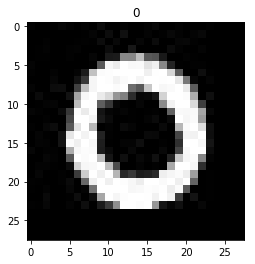

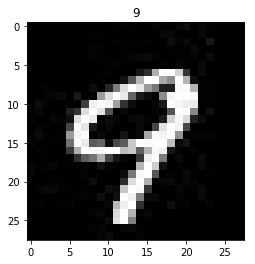

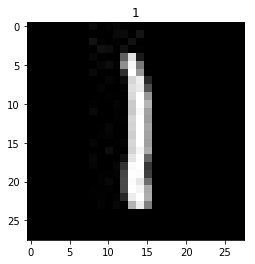

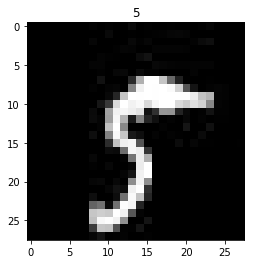

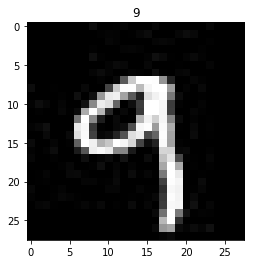

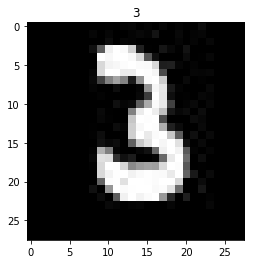

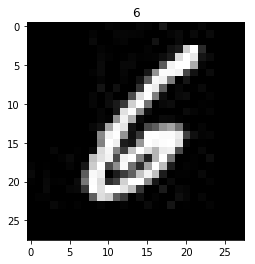

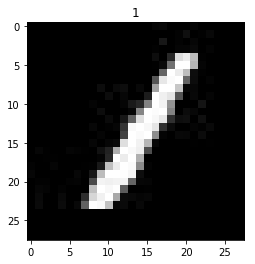

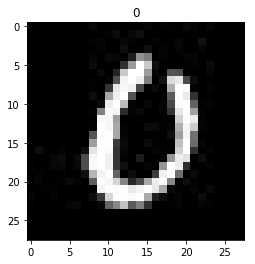

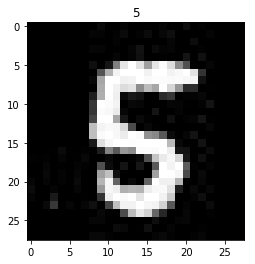

In [133]:
im_num = 0

for im_num in range(10):
    plt.title(f"{data.trn_ds[im_num][1]}")
    plt.imshow(data.trn_ds[im_num][0][0,:,:], cmap="gray")
    plt.show()

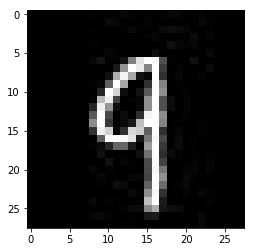

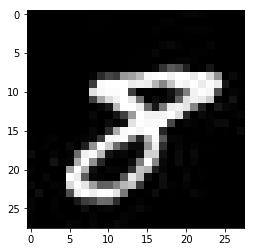

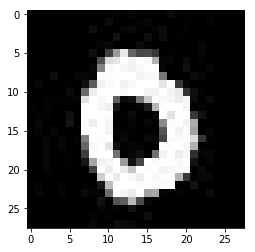

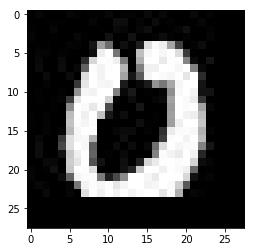

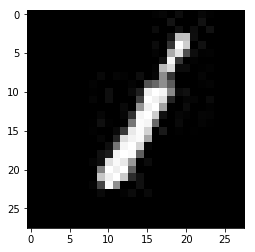

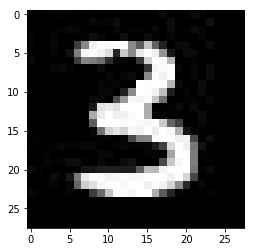

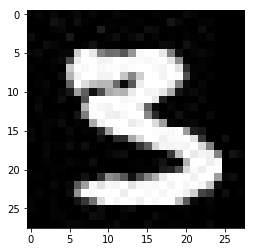

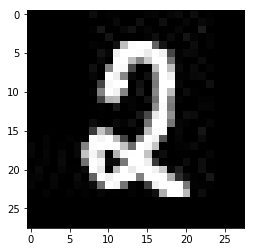

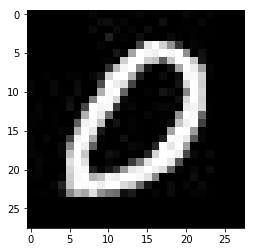

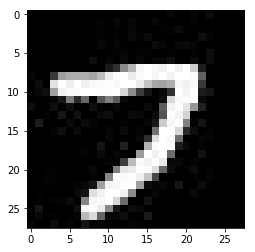

In [98]:
for im_num in range(10):
    #plt.title(f"{data.ts_ds[im_num][1]}")
    plt.imshow(data.test_ds[im_num][0][0,:,:], cmap="gray")
    plt.show()

## finding a good learning rate

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 82%|████████▏ | 457/560 [00:08<00:01, 52.99it/s, loss=4.41]


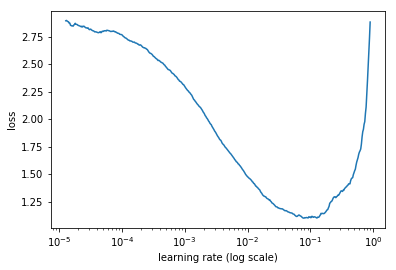

In [149]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf=learn.lr_find()
#learn.sched.plot_lr()
learn.sched.plot()